In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchview import draw_graph  # attempts to visualize computational graphs
import matplotlib.pyplot as plt
import ffmpeg_quality_metrics as ffqm  # for VMAF calculation
from PIL import Image
import cv2
import os
import random
import subprocess
import json
import numpy as np
# from datetime import datetime

# pip install ffmpeg_quality_metrics

# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


the-promotion.mp4
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/the-promotion.mp4
3782
printing frame number: 573


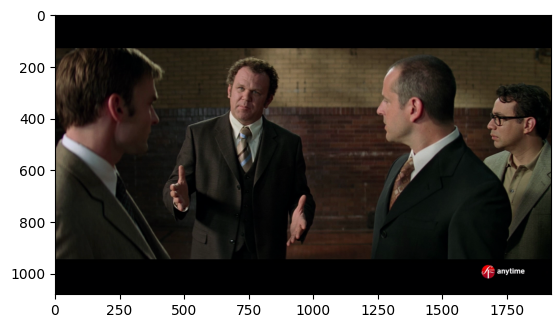

In [2]:
# läs in data och preprocessa

train = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train"
random_video = random.choice(os.listdir(train))
print(random_video)

video_path = os.path.join(train, random_video)
print(video_path)

cap = cv2.VideoCapture(video_path)

cap_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(cap_length)

random_frame = random.randrange(0, cap_length)
print("printing frame number:", random_frame)

cap.set(cv2.CAP_PROP_POS_FRAMES, 1000) # frame 1000

ret, frame = cap.read()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # avoid frame becoming blue

if ret:
    plt.imshow(frame_rgb)
    plt.show()
    
cap.release()
cv2.destroyAllWindows()


In [15]:
# runna inte igen!
compression_levels = [0, 23, 50, 75]   # 0 betyder inte alls komprimerad
results = []

for video in os.listdir(train):
    nr = 1
    video_path = os.path.join(str(nr), train, video)

    original_cap = cv2.VideoCapture(video_path)
    original_frame_count = int(original_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    original_cap.release()

    original_vmaf_scores = []

    for level in compression_levels:
        compressed_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data2", f"compressed_{level}_{nr}_{video}")
        subprocess.run(["ffmpeg", "-i", video_path, "-c:v", "libx264", "-crf", str(level), compressed_path])
    
    

        # ffmpeg med libvmaf filter för VMAF
        vmaf_command = [
            "ffmpeg",
            "-i", video_path,
            "-i", compressed_path,
            "-lavfi", f"[0:v][1:v]libvmaf=psnr=1:ssim=1:ms_ssim=1:log_fmt=json:log_path=vmaf_log_{level}.json",
            "-f", "null", "-"
        ]
        subprocess.run(vmaf_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

nr +=1

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57

KeyboardInterrupt: 

In [78]:
# Rätt version av kompression
compression_levels = [23, 50, 75]

for video in os.listdir(train):
    video_path = os.path.join(train, video)
    if not os.path.isfile(video_path):
        continue                    # continue skips the current iteration if video_path is not a file, to the next iteration (instead of break that exits loop completely)
    
    # Choose a random compression level
    level = random.choice(compression_levels)
    
    # Construct the compressed file path
    compressed_filename = f"compressed_{level}_{video}"
    # ÄNDRA TILL f"{video}_compressed_{level}""
    compressed_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data2", compressed_filename)
    
    # Compress the video
    subprocess.run(["ffmpeg", "-i", video_path, "-c:v", "libx264", "-crf", str(level), compressed_path])

    vmaf_command = [
        "ffmpeg",
        "-i", video_path,
        "-i", compressed_path,
        "-lavfi", f"[0:v][1:v]libvmaf=psnr=1:ssim=1:ms_ssim=1:log_fmt=json:log_path=vmaf_log_{level}_{video}.json",
        "-f", "null", "-"
    ]
    subprocess.run(vmaf_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)



ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57

In [81]:
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train")))    # varför 71?
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data2")))

71
70


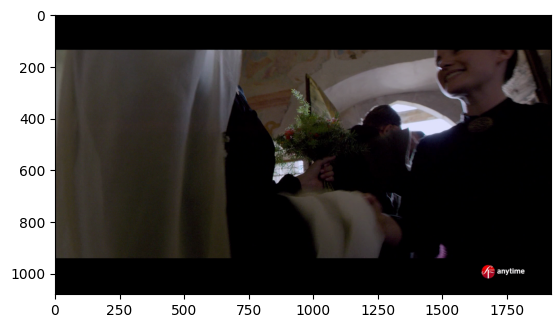

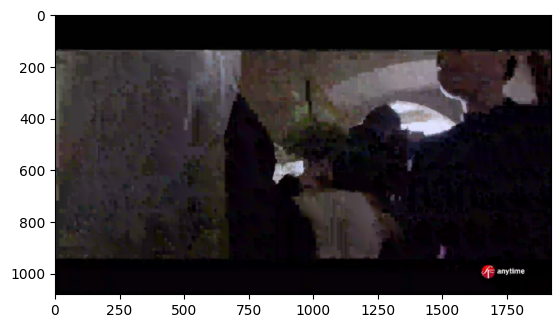

In [3]:
compressed_train = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data2"

video_path_0 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data/compressed_0_a-hidden-life.mp4"
video_path_23 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data/compressed_23_a-hidden-life.mp4"
video_path_50 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data/compressed_50_a-hidden-life.mp4"
video_path_75 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data/compressed_75_a-hidden-life.mp4"
    
cap_0 = cv2.VideoCapture(video_path_0)
cap_75 = cv2.VideoCapture(video_path_75)

cap_0.set(cv2.CAP_PROP_POS_FRAMES, 1000)
cap_75.set(cv2.CAP_PROP_POS_FRAMES, 1000)

ret_0, frame_0 = cap_0.read()
frame_rgb_0 = cv2.cvtColor(frame_0, cv2.COLOR_BGR2RGB)   # avoid frame becoming blue

if ret_0:
    plt.imshow(frame_rgb_0)
    plt.show()
    
    
ret_75, frame_75 = cap_75.read()
frame_rgb_75 = cv2.cvtColor(frame_75, cv2.COLOR_BGR2RGB)   # avoid frame becoming blue

if ret_75:
    plt.imshow(frame_rgb_75)
    plt.show()
    

im_0 = Image.fromarray(frame_0)
im_75 = Image.fromarray(frame_75)
im_0.save("im0_TEST.png")
im_75.save("im75_TEST.png")

cap_0.release()
cap_75.release()
cv2.destroyAllWindows()

In [ ]:
# metadata över längd
# ta bort början och slut
# hur långt kvar / 10s 
# frame rate?
# loopa ffmpeg

In [5]:
# kontrollera frames per second i datasetet

fps_list = []
for video in os.listdir(train):
    video_path = str(os.path.join(train, video))

    original_cap = cv2.VideoCapture(video_path)
    fps = int(original_cap.get(cv2.CAP_PROP_FPS))
    original_frame_count = int(original_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps_list.append(fps)
    
    print(video_path, fps)
    original_cap.release()
    

print(min(fps_list))
print(max(fps_list))

/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/maria-wern-svart-fjaril.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/army-of-darkness.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/wallander-forsvunnen.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/the-player.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/its-a-mad-mad-mad-mad-world.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/the-mothman-prophecies.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/road-house.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/knife-fight.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/maria-wern-alla-de-stillsamma-doda.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/tiny-tim-king-for-a-day.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/satans-slaves.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/silent-

OpenCV: Couldn't read video stream from file "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/.DS_Store"


/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/wheel-of-fortune-and-fantasy.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/maria-wern-drommen-forde-dig-vilse.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/bortom-tingri.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/son-of-a-gun.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/rocky-balboa.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/gone-in-60-seconds-1974.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/green-book.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/chitty-chitty-bang-bang.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/les-choses-quon-dit-les-choses-quon-fait.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/delicatessen.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/maria-wern-drommar-ur-sno.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data

In [84]:
# dataset med bilder skapas
# kör inte igen
nr = 1

video_files = sorted(os.listdir(compressed_train))

for video in video_files:
    video_path = os.path.join(compressed_train, video)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frameNr = 0
    
    while True:
        ret, frame = cap.read()
        
        if ret:
            if frameNr % 250 == 0:
                # Save every 250th frame
                cv2.imwrite(f'/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed2/train_{nr}_{video}_frame{frameNr}.jpg', frame)
                nr += 1
        else:
            break
        
        frameNr += 1
    
    cap.release()


In [89]:
# dataset med REFERENS-bilder skapas
# kör inte igen
nr = 1

video_files = sorted(os.listdir(train))

for video in video_files:
    video_path = os.path.join(train, video)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frameNr = 0
    
    while True:
        ret, frame = cap.read()
        
        if ret:
            if frameNr % 250 == 0:
                # Save every 250th frame
                cv2.imwrite(f'/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train/train_{nr}_{video}_frame{frameNr}.jpg', frame)
                nr += 1
        else:
            break
        
        frameNr += 1
    
    cap.release()


OpenCV: Couldn't read video stream from file "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/.DS_Store"


/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train/train_359_maria-wern-alla-de-stillsamma-doda.mp4_frame1000.jpg
/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed2/train_633_compressed_75_maria-wern-alla-de-stillsamma-doda.mp4_frame1000.jpg


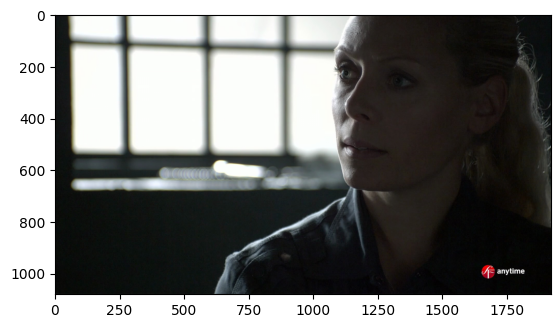

In [4]:
"""
VMAF
Algorithm:
1) Find all uncompressed frame versions. 
2) Remove frames that will not be used
3) Crop in a predetermined amount of patches, store in a new folder with descriptive names
4) loop through folder and calculate VMAF, store VMAF values in a new file 
"""

reference_frames = []
compressed_frames = []
# compressed_23 = []
# compressed_50 = []
# compressed_75 = []

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train", image)
    
    reference_frames.append(im_path)

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed2"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed2", image)
    
    compressed_frames.append(im_path)
        

def sort_by_movie_ref(path):
    return path.split("_")[3]    # filmnamn
   
def sort_by_movie_comp(path):
    # print(path.split("_")[6])
    return path.split("_")[6]     # filmnamn


def sort_by_frame(path):
    # print(path.split("_")[-1] )
    return path.split("_")[-1]         # bara nr


reference_sorted = sorted(reference_frames, key=sort_by_movie_ref)
compressed_sorted = sorted(compressed_frames, key=sort_by_movie_comp)

reference_sorted_by_frames = sorted(reference_sorted, key=sort_by_frame)
compressed_sorted_by_frames = sorted(compressed_sorted, key=sort_by_frame)


print(reference_sorted_by_frames[100])
print(compressed_sorted_by_frames[100])

plt.imshow(plt.imread(reference_sorted_by_frames[100]))  
# plt.imshow(plt.imread(compressed_sorted_by_frames[100]))    


# göra cv2.COLOR_BGR2RGB på alla?
    

In [162]:
# behöver göras om, ska croppas i ca 8-9 delar (behöver de vara kvadratiska?????)
def crop_video(im_path):
    
    # kolla även på den här: https://stackoverflow.com/questions/47636816/automated-cropping-of-images-using-python 
    
    # https://www.geeksforgeeks.org/python-pil-image-crop-method/ :
    
    for im_path in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train"):
        try:
            im = Image.open(im_path)
            
        except IOError as e:
            print("Problem opening", im_path, ":", e)
            continue
        
        
        width, height = im.size
        
        # name, extension = os.path.splitext(im_path)
        
        # print(name + '_cropped.jpg')         # också vilken "version" av crop (vilken del av bilden)!
        # im_cropped.save(os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop", name + '_cropped.jpg'))
        
        
              

im_path = reference_sorted_by_frames[100]
im = Image.open(im_path)
savedir = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop"
width, height = im.size

left1 = 0
top1 = 0
right1 = width/9
bottom1 = height/9

left2 = width/9
top2 = height/9
right2 = width/9
bottom2 = height/9

start_pos = start_x, start_y = (0,0)  
# cropped_image_size = w, h = (240, 135)         # 8 delar
cropped_image_size = w, h = (135, 135)


"""num = 1
for col_i in range (width):
    for row_i in range (height):
        x = start_x + col_i*w
        y = start_y + row_i*h
        crop = im.crop((x, y, x+w*row_i, y+h*col_i))
        print(crop)
        # save_to= os.path.join(savedir, reference_sorted_by_frames[100] ,"_cropped")
        # cv2.imwrite(f"/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_{num}_{im_path}", crop)
        # crop.save(crop, savedir)
        # crop.save(save_to.format(num))
        # crop.save(save_to)
        num += 1"""
        

"""for col_i in range (width):
    for row_i in range (height):
        x = start_x + col_i*w 
        y = start_y + row_i*h
        crop = im.crop((x, y, x, y))
        print(crop)"""

        
# im1 = im.crop((left1, top1, right1, bottom1))
# im2 = im.crop((left2, top2, right2, bottom2))

# print(im1.size)

# plt.imshow(im1) 
    
    
    
    # subprocess.run(["ffmpeg", "-i", video_path, "-vf", "crop=224:224", "-c:a", "copy", output_path])
    
# crop_video(reference_sorted_by_frames[100])

<PIL.Image.Image image mode=RGB size=1920x1080 at 0x164F444C0>
<PIL.Image.Image image mode=RGB size=1920x810 at 0x164F15300>
<PIL.Image.Image image mode=RGB size=1920x540 at 0x164F44730>
<PIL.Image.Image image mode=RGB size=1920x270 at 0x164F15300>
<PIL.Image.Image image mode=RGB size=1920x0 at 0x164F44790>


ValueError: Coordinate 'lower' is less than 'upper'

In [11]:
for im in os.listdir(images_train):
    im_path = os.path.join(images_train, im)
    output_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop", f"cropped_{im}")
    crop_video(im_path, output_path)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57

In [ ]:
for im in os.listdir(images_train_compressed2):
    im_path = os.path.join(images_train_compressed2, im)
    output_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop", f"cropped_{im}")
    crop_video(im_path, output_path)

In [ ]:
# Example of cropping and displaying a random frame from a video
random_video_path = os.path.join(train, random.choice(os.listdir(train)))
cap = cv2.VideoCapture(random_video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
random_frame = random.randint(0, frame_count - 1)
cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame)

ret, frame = cap.read()
if ret:
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()

cap.release()
cv2.destroyAllWindows()

(1080, 1920, 3)
start row 	-  540
end row 	-  764
start column 	-  540
end column 	-  764
(224, 224, 3)


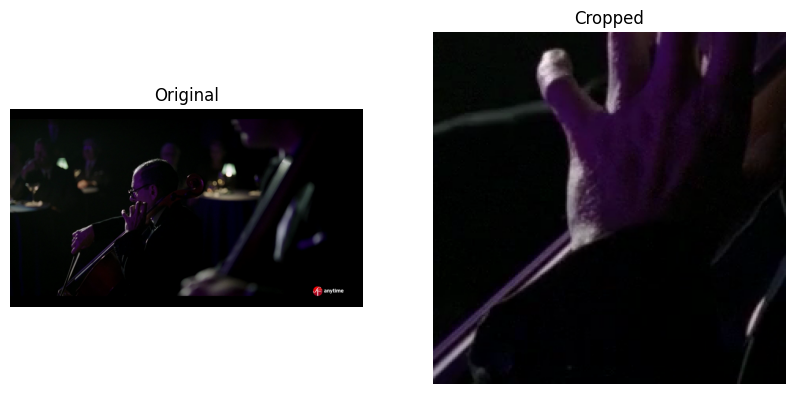

In [131]:
# test-tillämpning av crop, mitten-klippning

image_shape = frame_rgb.shape

print(frame_rgb.shape)

# cropped_pieces = []

# imgwidth = frame_rgb.shape[0]
# imgheight = frame_rgb.shape[1]

length = 224
width = 224

start_row = 540
start_column = start_row

end_row = length + start_row

end_column = width + start_column

print("start row \t- ", start_row)
print("end row \t- ", end_row)
print("start column \t- ", start_column)
print("end column \t- ", end_column)

image_cropped = frame_rgb[start_row:end_row, start_column:end_column]


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

ax1.axis("off")
ax1.title.set_text('Original')

ax2.axis("off")
ax2.title.set_text("Cropped")

ax1.imshow(frame_rgb)
ax2.imshow(image_cropped)

print(image_cropped.shape)     # (224, 224, 3)


In [ ]:
"""
VMAF terminal command:
ffmpeg-quality-metrics distorted.jpg reference.jpg --metrics vmaf

Python Subprocess:
From https://www.datacamp.com/tutorial/python-subprocess : 
It's like giving commands to your computer using Python instead of typing them directly into the command prompt. This module makes it easy to automate tasks and integrate other programs with your Python code.
This can be useful for tasks such as log analysis, data processing, and text manipulation.

"""

def process_image(dist_im, ref_im):
    command = ['your_command', 'arguments', image_path]
    output = subprocess.check_output(command)     # os.system()?

    output_file = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/vmaf.txt"

    with open(output_file, 'wb') as f:
            f.write(output)
 
        
folder_path1 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop"
folder_path2 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop"


for filename in os.listdir(folder_path1):
    if filename.endswith('.jpg') or filename.endswith('.png'):  
        image_path = os.path.join(folder_path1, filename)
        process_image(image_path)

In [ ]:
"""
Här ska vi köra lite analyser, titta på distributionen av VMAF för olika ställen i bilden. 

- Kolla på medelvärde och standardavvikelse bland olika delar i bilden
- Probability distribution
- Spara detta i Excel-ark/annat?
"""

In [ ]:
"""
model.eval() is a kind of switch for some specific layers/parts of the model that behave differently 
during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. 
You need to turn them off during model evaluation, and .eval() will do it for you.
In addition, the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation:
"""

model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
model.eval()    # BUT, don't forget to turn back to training mode after eval step: model.train()